In [1]:
!pip install torchattacks


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


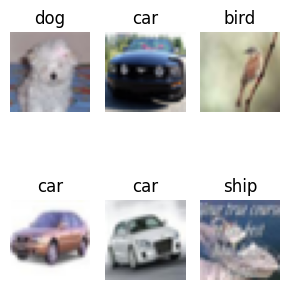

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(3, 4))

for i in range(batch_size):
    plt.subplot(2, 3, i+1)
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

model.fc = nn.Linear(512, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [8]:
num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/8, Loss: 0.9628, Train Accuracy: 0.6771, Val Accuracy: 0.7172
Epoch 2/8, Loss: 0.6594, Train Accuracy: 0.7778, Val Accuracy: 0.7632
Epoch 3/8, Loss: 0.5226, Train Accuracy: 0.8212, Val Accuracy: 0.7878
Epoch 4/8, Loss: 0.4153, Train Accuracy: 0.8603, Val Accuracy: 0.7957
Epoch 5/8, Loss: 0.3512, Train Accuracy: 0.8807, Val Accuracy: 0.7972
Epoch 6/8, Loss: 0.2707, Train Accuracy: 0.9084, Val Accuracy: 0.8027
Epoch 7/8, Loss: 0.2152, Train Accuracy: 0.9252, Val Accuracy: 0.7908
Epoch 8/8, Loss: 0.1771, Train Accuracy: 0.9412, Val Accuracy: 0.7978


In [9]:
torch.save(model.state_dict(), 'cifar10_model.pth')


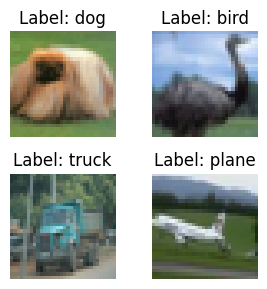

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

plt.figure(figsize=(3, 3))

for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
model.load_state_dict(torch.load('cifar10_model.pth'))


<All keys matched successfully>

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
images = images.to(device)
outputs = model(images)


In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  dog   bird  truck plane


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        model = model.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        labels = labels.to(device)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 79 %


In [15]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        model = model.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    if classname in total_pred and total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'No predictions made or no test samples for class: {classname}')


Accuracy for class: plane is 86.1 %
Accuracy for class: car   is 89.4 %
Accuracy for class: bird  is 75.0 %
Accuracy for class: cat   is 64.7 %
Accuracy for class: deer  is 77.8 %
Accuracy for class: dog   is 67.8 %
Accuracy for class: frog  is 87.6 %
Accuracy for class: horse is 83.1 %
Accuracy for class: ship  is 79.7 %
Accuracy for class: truck is 86.6 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Success Rate: 0.7875


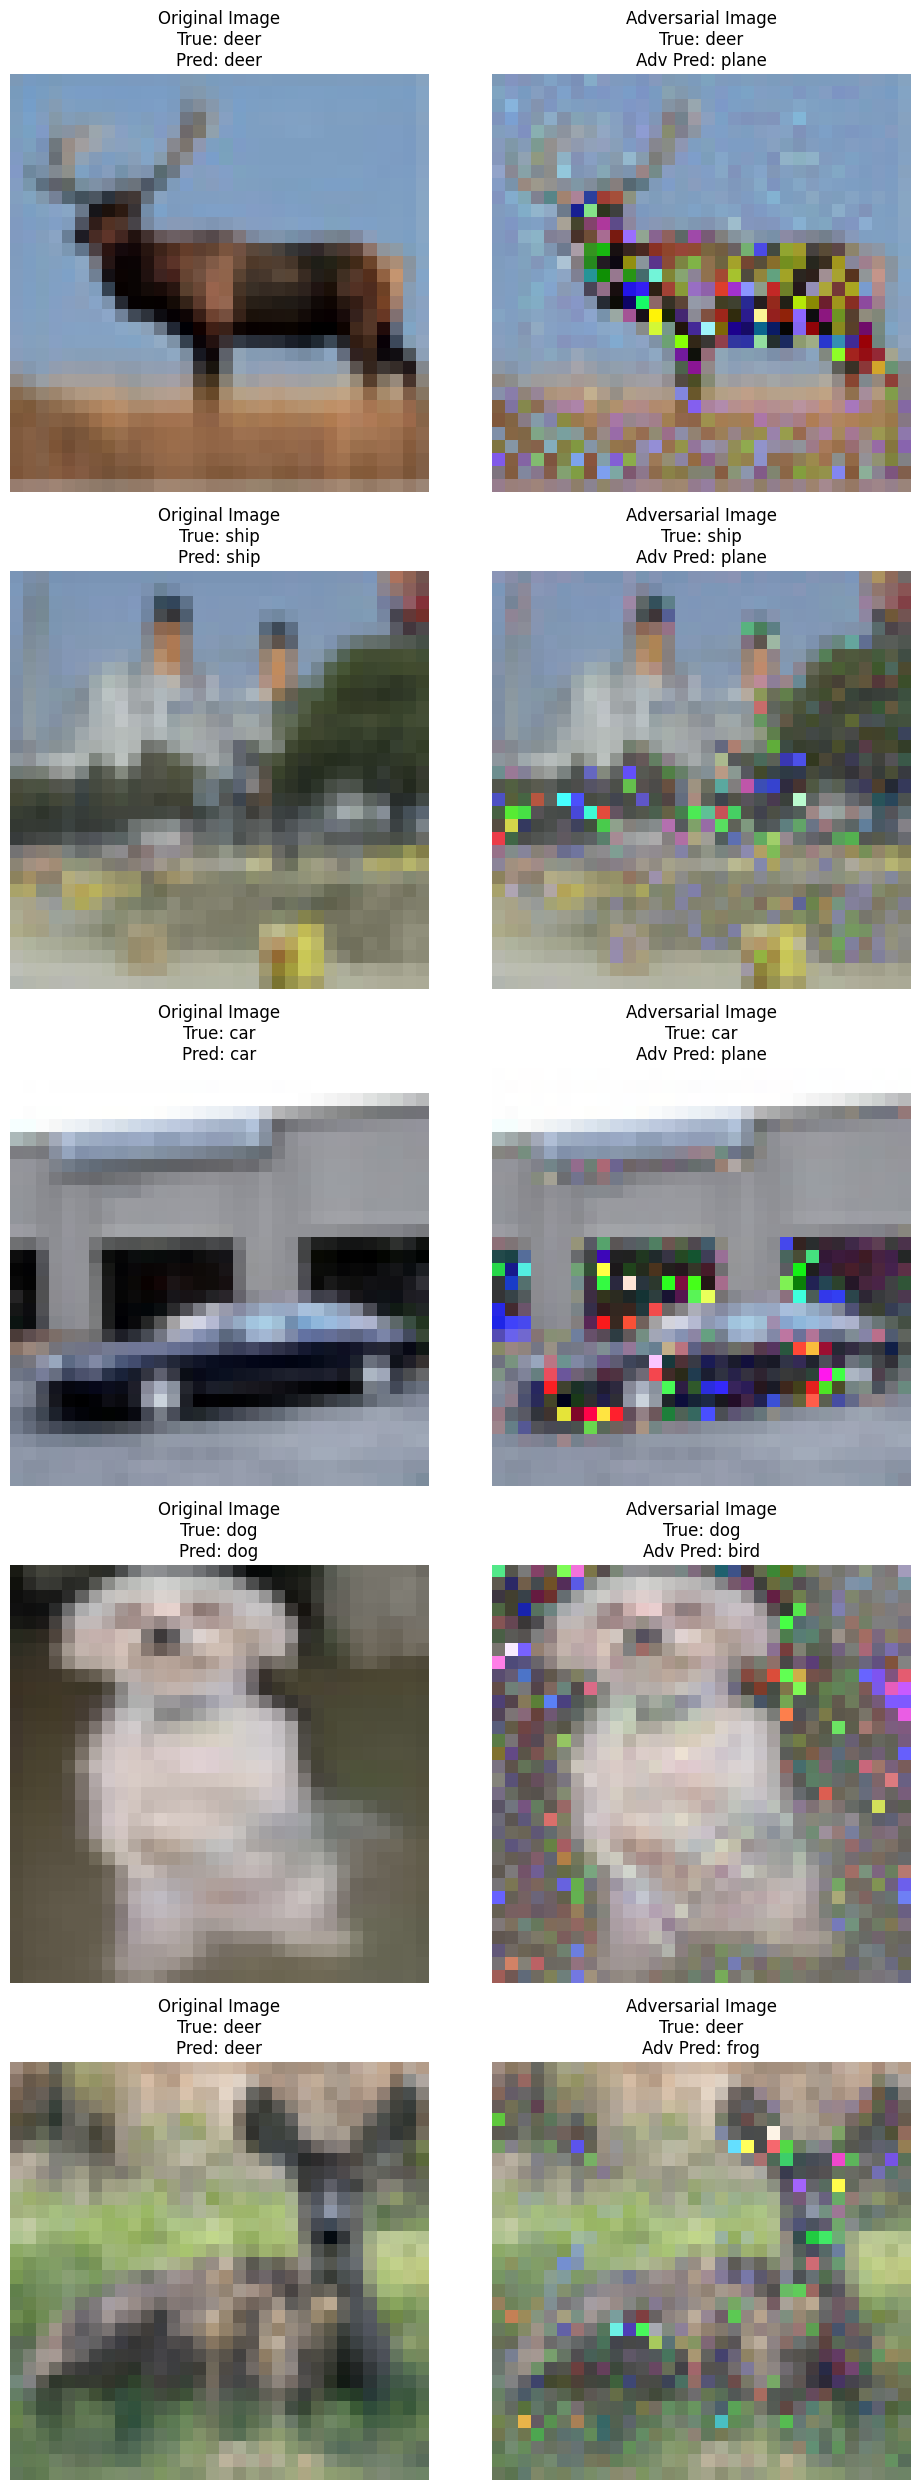

In [16]:
import torchattacks

attack_eadl1 = torchattacks.EADL1(model, kappa=0, lr=0.01, binary_search_steps=9, max_iterations=100, abort_early=True, initial_const=0.001, beta=0.001)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_eadl1(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Success Rate: 0.6375


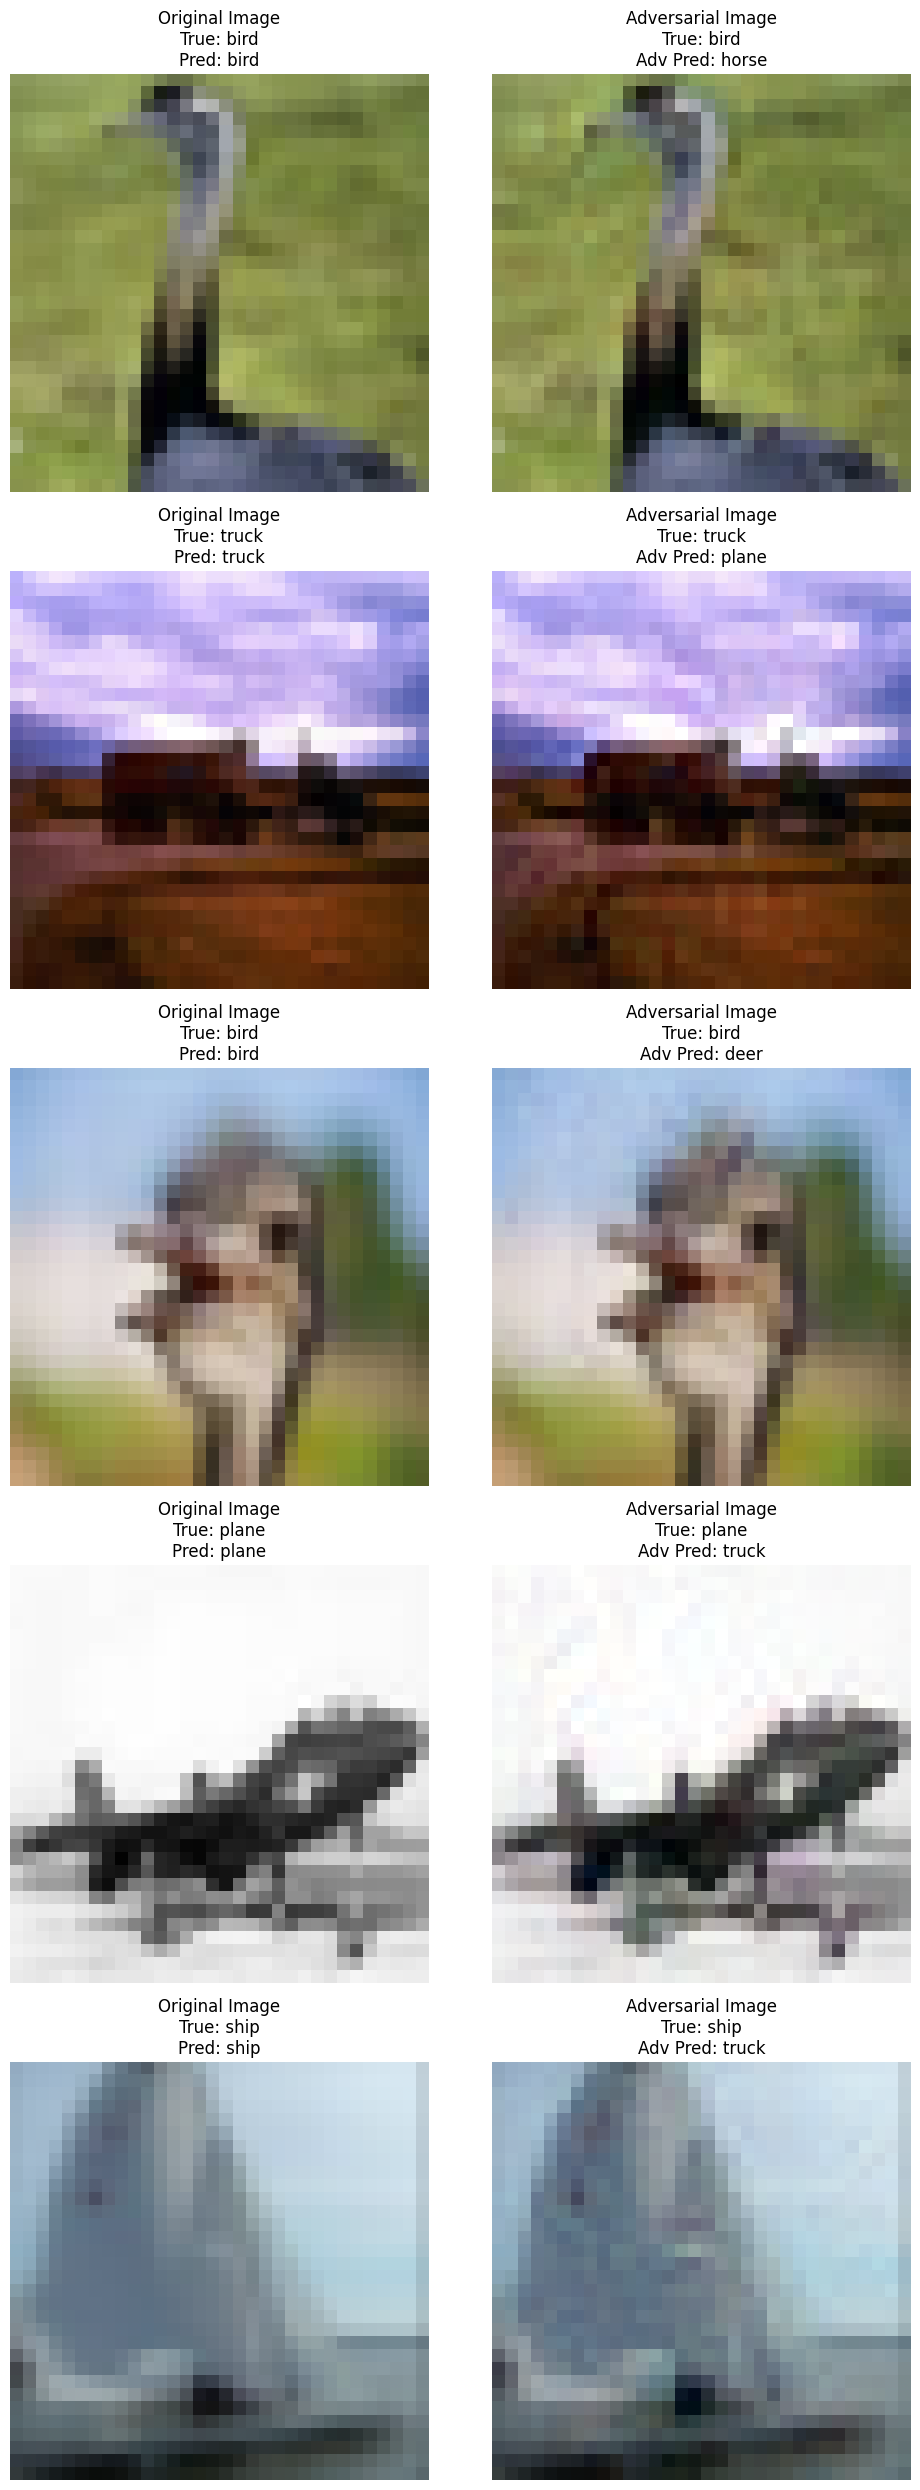

In [17]:
import torchattacks

# Modifying the parameters significantly from their defaults
attack_eadl1 = torchattacks.EADL1(model, kappa=10, lr=0.1, binary_search_steps=1, max_iterations=500, abort_early=False, initial_const=1, beta=0.1)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_eadl1(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Success Rate: 0.7750


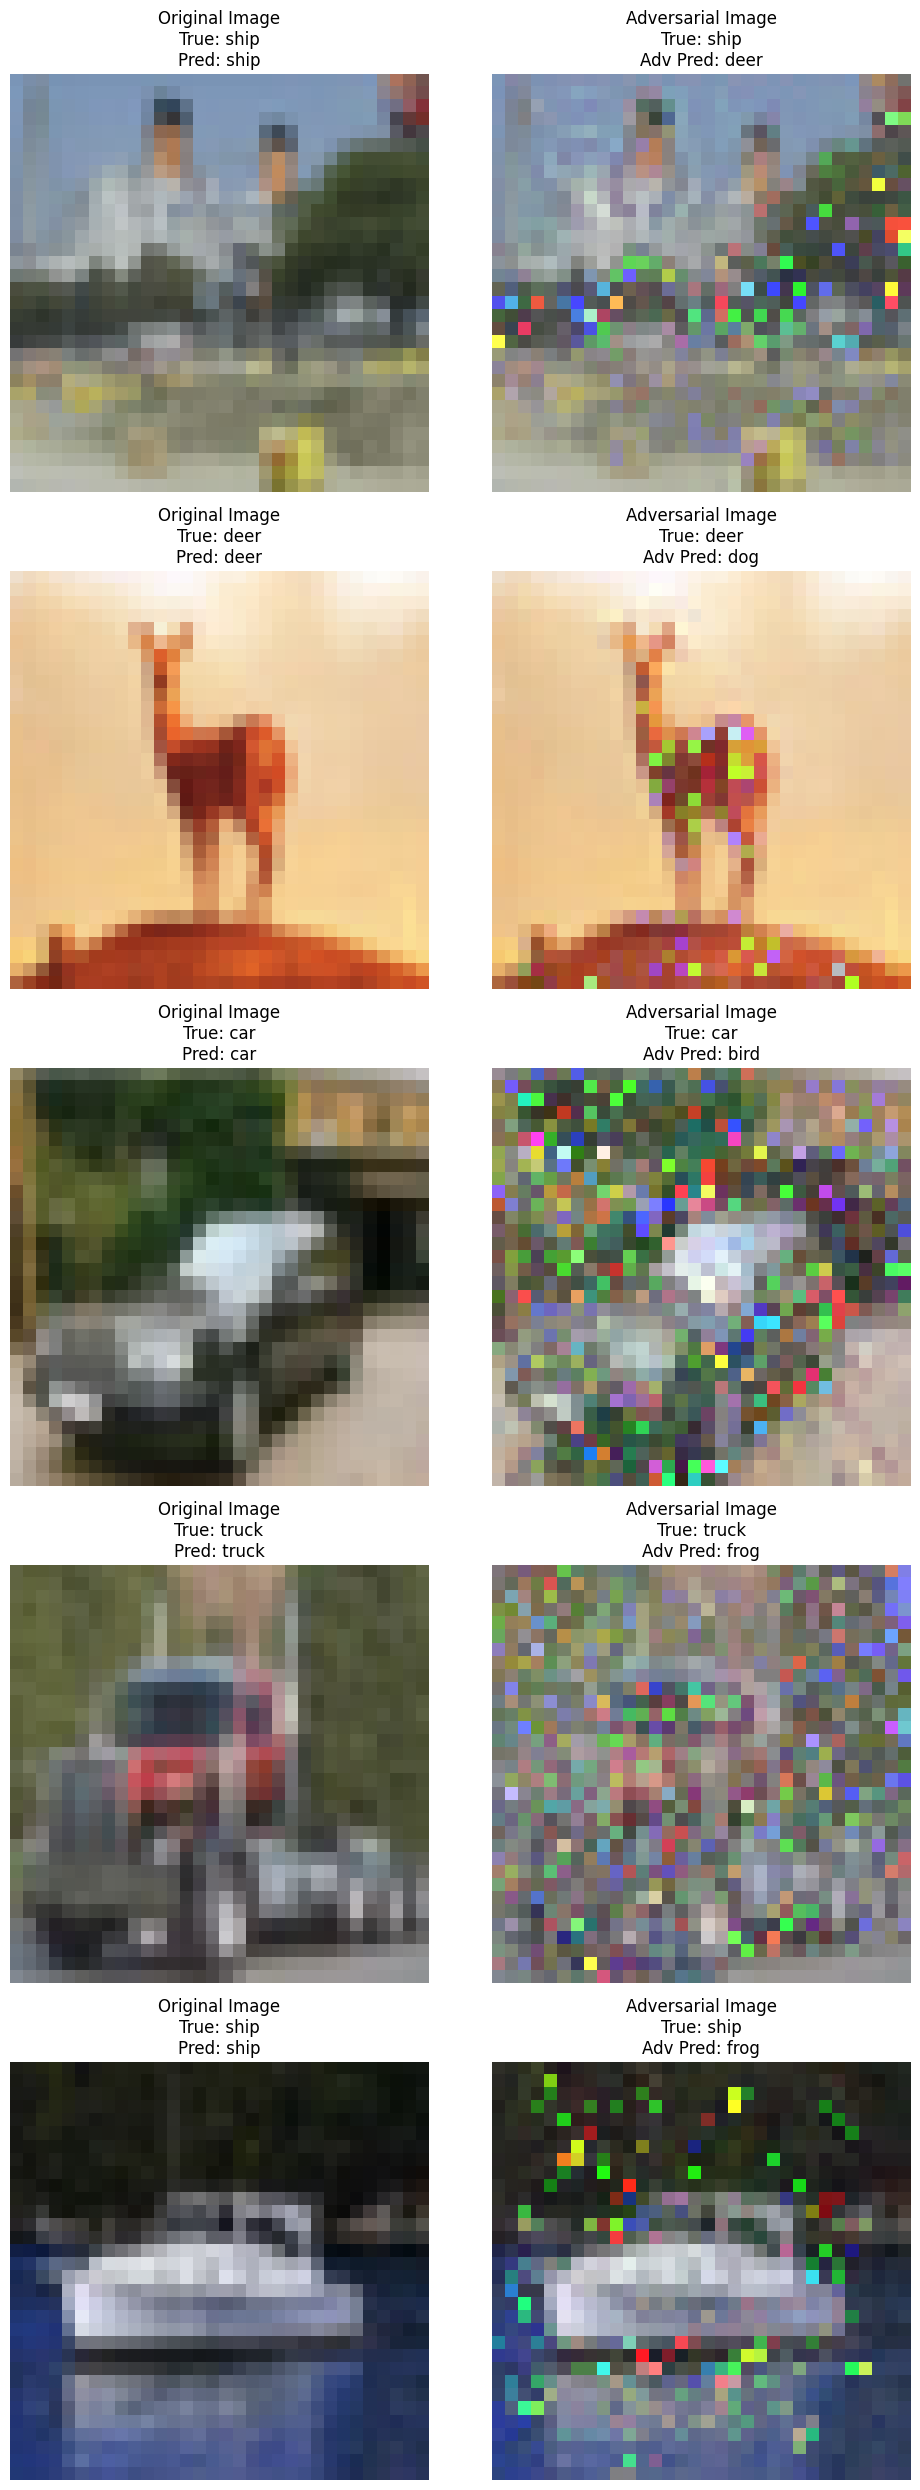

In [18]:
import torchattacks


#Keeping kappa parameter increased to 10, other parameters set to default
attack_eadl1 = torchattacks.EADL1(model, kappa=10, lr=0.01, binary_search_steps=9, max_iterations=100, abort_early=True, initial_const=0.001, beta=0.001)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_eadl1(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Params: {'kappa': 0, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001}, Success Rate: 0.8250
Params: {'kappa': 10, 'beta': 0.01, 'lr': 0.1, 'binary_search_steps': 1, 'max_iterations': 100, 'initial_const': 1}, Success Rate: 0.7500
Params: {'kappa': 5, 'beta': 0.005, 'lr': 0.05, 'binary_search_steps': 5, 'max_iterations': 500, 'initial_const': 0.01}, Success Rate: 0.8000
Params: {'kappa': 7, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 1000, 'initial_const': 0.001}, Success Rate: 0.8625
Params: {'kappa': 0, 'beta': 0.005, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001}, Success Rate: 0.8375
Params: {'kappa': 0, 'beta': 0.001, 'lr': 0.05, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001}, Success Rate: 0.8125
Params: {'kappa': 3, 'beta': 0.002, 'lr': 0.02, 'binary_search_steps': 7, 'max_iterations': 800, 'initial_const': 0.005}, Success Rate: 0.7750
Para

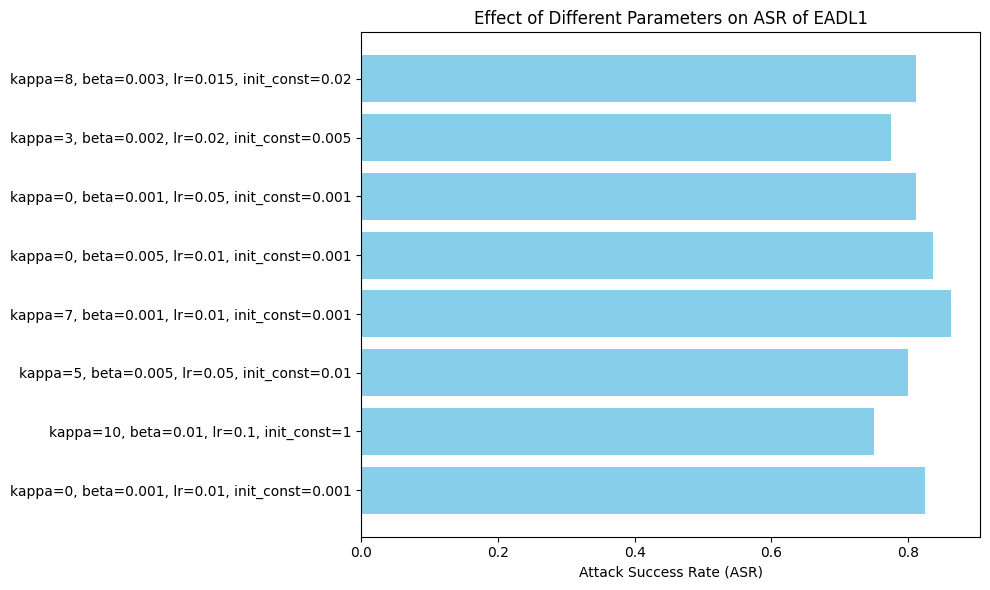

In [28]:
import torchattacks
import matplotlib.pyplot as plt

param_sets = [
    {'kappa': 0, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001},  # Default parameters
    {'kappa': 10, 'beta': 0.01, 'lr': 0.1, 'binary_search_steps': 1, 'max_iterations': 100, 'initial_const': 1},  # Opposite of default
    {'kappa': 5, 'beta': 0.005, 'lr': 0.05, 'binary_search_steps': 5, 'max_iterations': 500, 'initial_const': 0.01},  # Middle values
    {'kappa': 7, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 1000, 'initial_const': 0.001},  # Tweak kappa
    {'kappa': 0, 'beta': 0.005, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001},  # Tweak beta
    {'kappa': 0, 'beta': 0.001, 'lr': 0.05, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001},  # Tweak lr
    {'kappa': 3, 'beta': 0.002, 'lr': 0.02, 'binary_search_steps': 7, 'max_iterations': 800, 'initial_const': 0.005},  # Combined tweaks
    {'kappa': 8, 'beta': 0.003, 'lr': 0.015, 'binary_search_steps': 4, 'max_iterations': 600, 'initial_const': 0.02}  # Another set of tweaks
]

asr_results = []

torch.set_grad_enabled(True)

for params in param_sets:
    attack_eadl1 = torchattacks.EADL1(model, kappa=params['kappa'], lr=params['lr'], binary_search_steps=params['binary_search_steps'], max_iterations=params['max_iterations'], abort_early=True, initial_const=params['initial_const'], beta=params['beta'])

    successful_attacks = 0
    total_samples = 0
    examples = []
    num_batches_to_process = 10
    batch_size = 8

    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= num_batches_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        adv_images = attack_eadl1(images[:batch_size], labels[:batch_size])

        original_predictions = model(images[:batch_size])
        adversarial_predictions = model(adv_images)

        original_pred_labels = torch.argmax(original_predictions, dim=1)
        adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

        for i in range(len(labels[:batch_size])):
            if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
                successful_attacks += 1
                examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

        total_samples += len(labels[:batch_size])

        torch.cuda.empty_cache()

    success_rate = successful_attacks / total_samples
    asr_results.append((params, success_rate))
    print(f'Params: {params}, Success Rate: {success_rate:.4f}')

torch.set_grad_enabled(False)

fig, ax = plt.subplots(figsize=(10, 6))

param_labels = [f"kappa={p['kappa']}, beta={p['beta']}, lr={p['lr']}, init_const={p['initial_const']}" for p, _ in asr_results]
asr_values = [asr for _, asr in asr_results]

ax.barh(param_labels, asr_values, color='skyblue')
ax.set_xlabel('Attack Success Rate (ASR)')
ax.set_title('Effect of Different Parameters on ASR of EADL1')
plt.tight_layout()
plt.show()


**Attack Success Rate Calculation of EADEN**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Success Rate: 0.7750


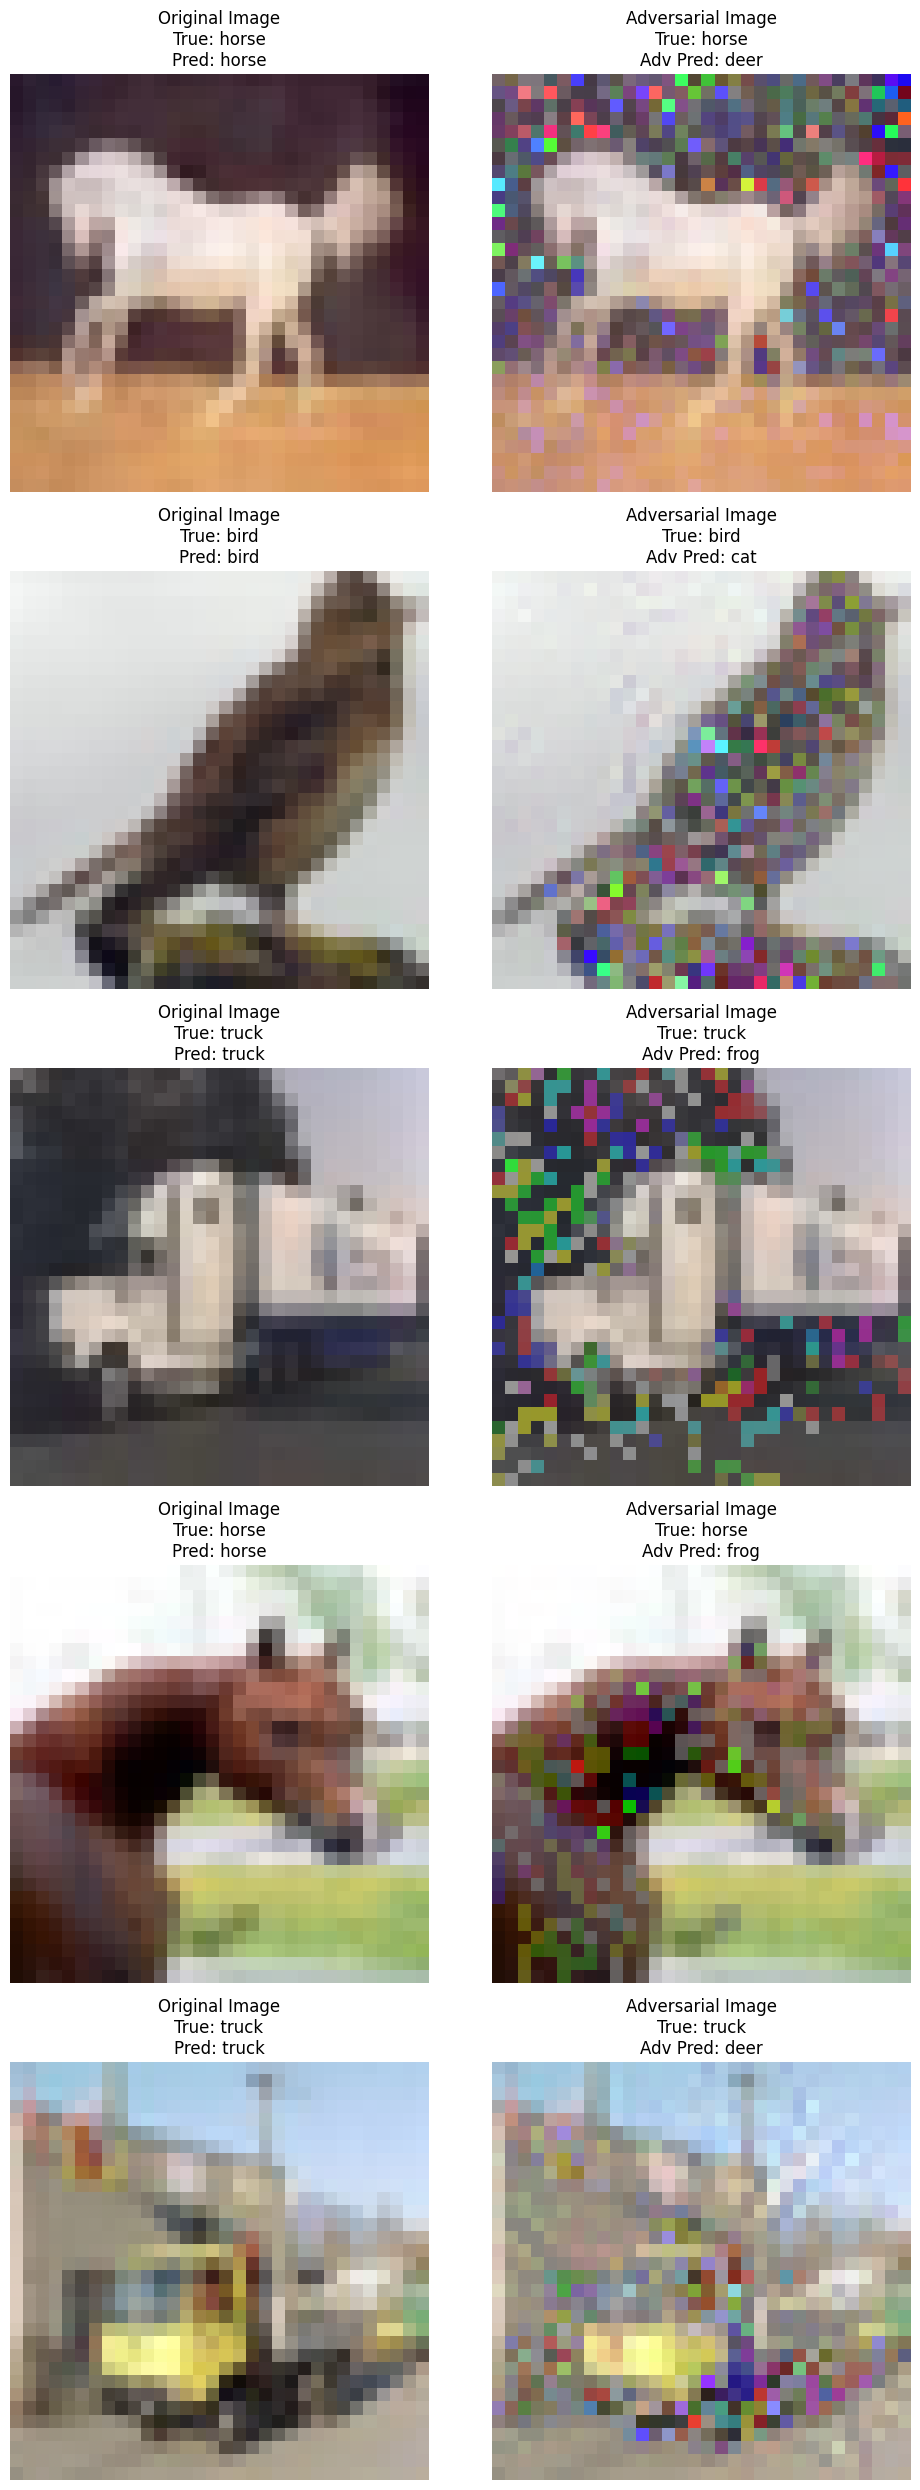

In [21]:
import torchattacks

attack_eaden = torchattacks.EADEN(model, kappa=0, lr=0.01, binary_search_steps=9, max_iterations=100, abort_early=True, initial_const=0.001, beta=0.001)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_eaden(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


In [22]:
import torchattacks

# Modifying the parameters significantly from their defaults
attack_eaden = torchattacks.EADEN(model, kappa=10, lr=0.001, binary_search_steps=1, max_iterations=1000, abort_early=False, initial_const=1, beta=0.1)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_eaden(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Success Rate: 0.0000
No successful attacks to display.


Success Rate: 0.1125


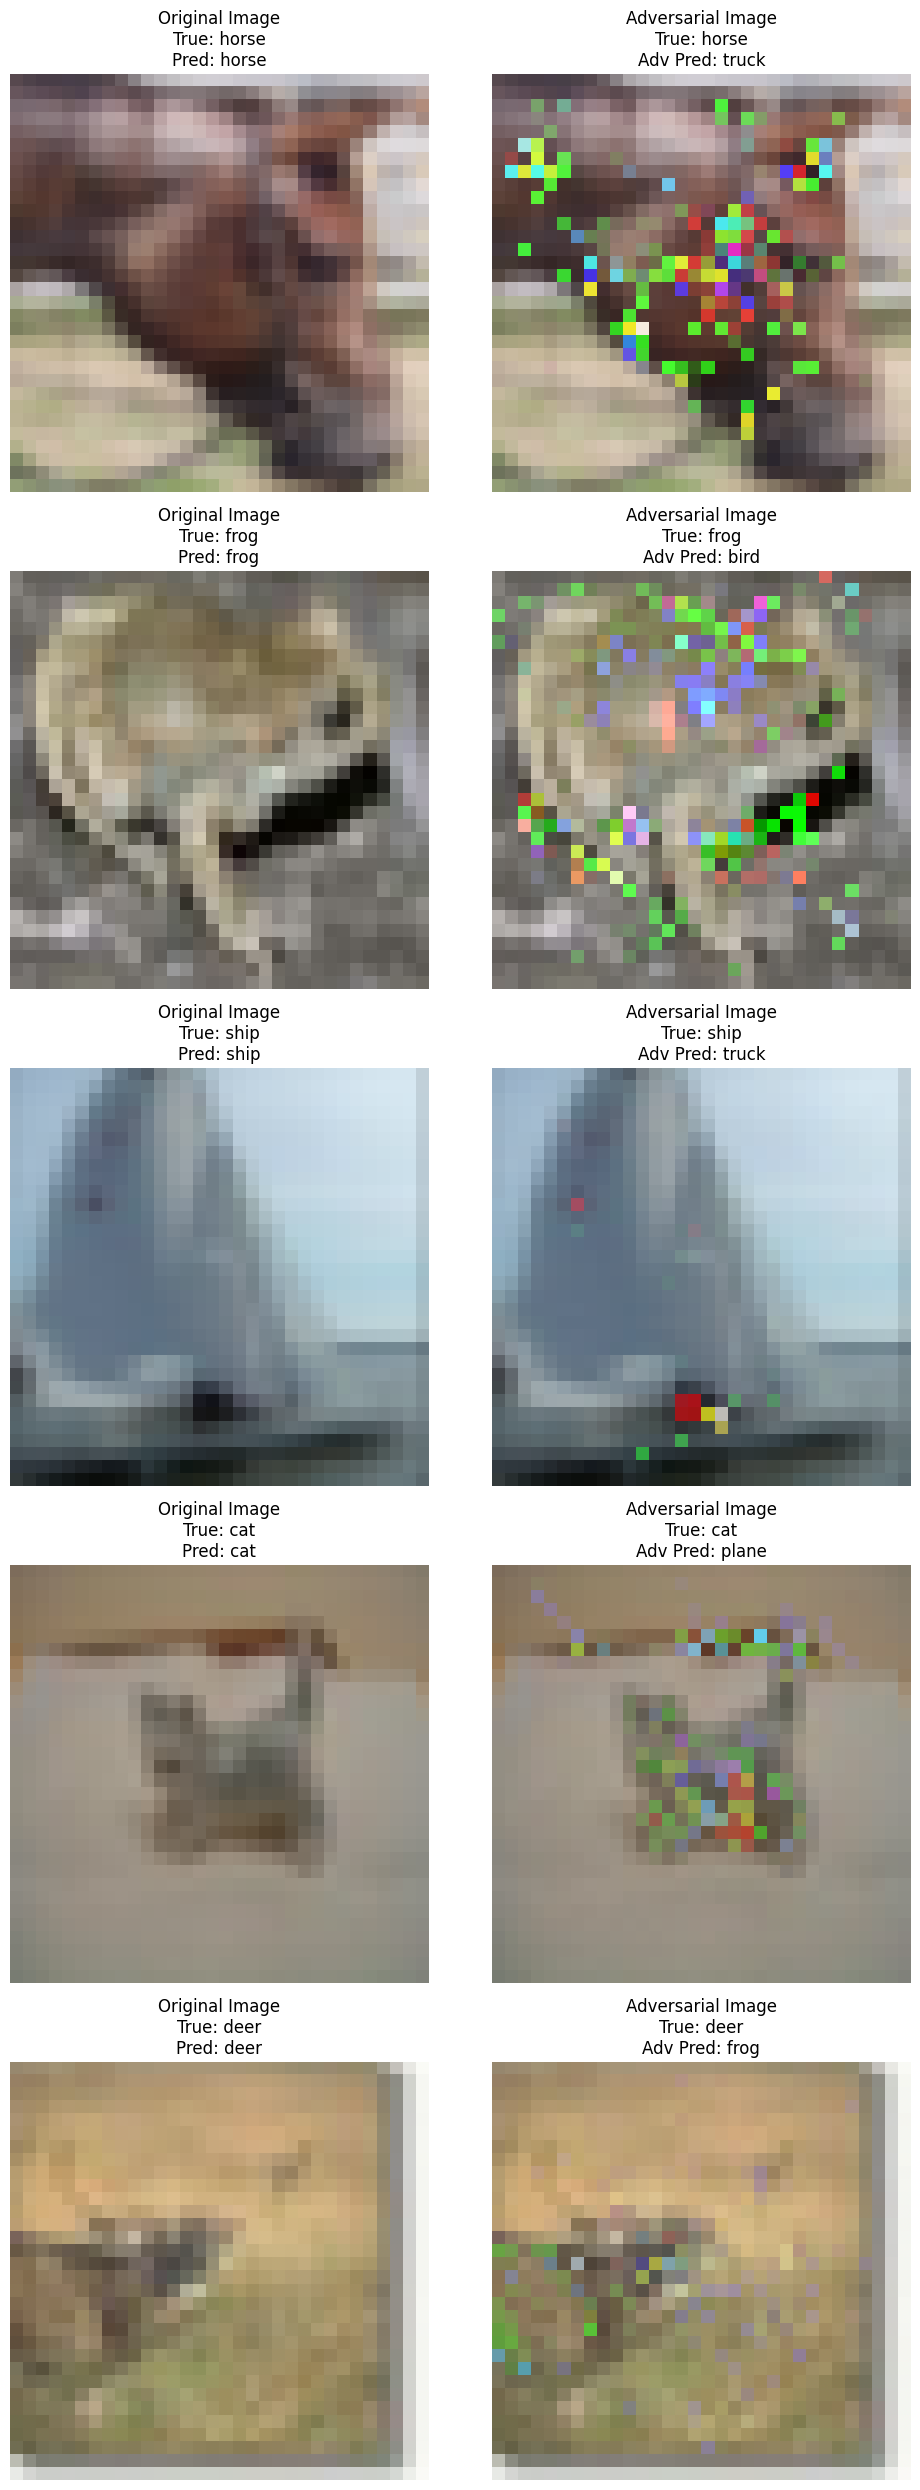

In [23]:
import torchattacks

# Tweaking the parameters to the less extreme ones
attack_eaden = torchattacks.EADEN(model, kappa=5, lr=0.001, binary_search_steps=3, max_iterations=500, abort_early=False, initial_const=0.1, beta=0.01)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_eaden(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Params: {'kappa': 0, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001}, Success Rate: 0.8250
Params: {'kappa': 10, 'beta': 0.01, 'lr': 0.1, 'binary_search_steps': 1, 'max_iterations': 100, 'initial_const': 1}, Success Rate: 0.7500
Params: {'kappa': 5, 'beta': 0.005, 'lr': 0.05, 'binary_search_steps': 5, 'max_iterations': 500, 'initial_const': 0.01}, Success Rate: 0.8250
Params: {'kappa': 7, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 1000, 'initial_const': 0.001}, Success Rate: 0.8625
Params: {'kappa': 0, 'beta': 0.005, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001}, Success Rate: 0.7750
Params: {'kappa': 0, 'beta': 0.001, 'lr': 0.05, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001}, Success Rate: 0.8625
Params: {'kappa': 3, 'beta': 0.002, 'lr': 0.02, 'binary_search_steps': 7, 'max_iterations': 800, 'initial_const': 0.005}, Success Rate: 0.8125
Para

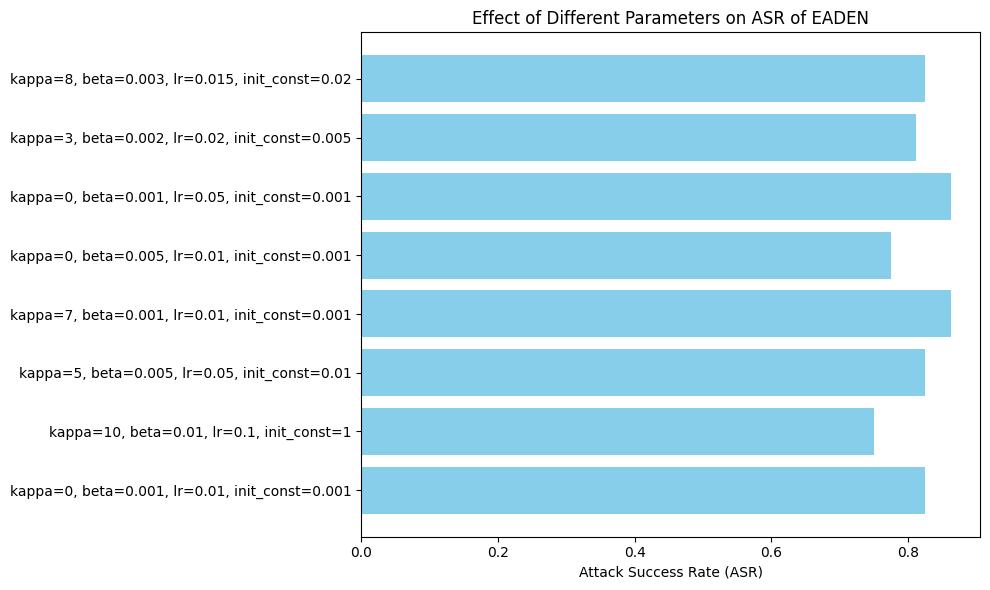

In [24]:
import torchattacks
import matplotlib.pyplot as plt

param_sets_eaden = [
    {'kappa': 0, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001},  # Default parameters
    {'kappa': 10, 'beta': 0.01, 'lr': 0.1, 'binary_search_steps': 1, 'max_iterations': 100, 'initial_const': 1},  # Opposite of default
    {'kappa': 5, 'beta': 0.005, 'lr': 0.05, 'binary_search_steps': 5, 'max_iterations': 500, 'initial_const': 0.01},  # Middle values
    {'kappa': 7, 'beta': 0.001, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 1000, 'initial_const': 0.001},  # Tweak kappa
    {'kappa': 0, 'beta': 0.005, 'lr': 0.01, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001},  # Tweak beta
    {'kappa': 0, 'beta': 0.001, 'lr': 0.05, 'binary_search_steps': 9, 'max_iterations': 100, 'initial_const': 0.001},  # Tweak lr
    {'kappa': 3, 'beta': 0.002, 'lr': 0.02, 'binary_search_steps': 7, 'max_iterations': 800, 'initial_const': 0.005},  # Combined tweaks
    {'kappa': 8, 'beta': 0.003, 'lr': 0.015, 'binary_search_steps': 4, 'max_iterations': 600, 'initial_const': 0.02}  # Another set of tweaks
]

asr_results_eaden = []

torch.set_grad_enabled(True)

for params in param_sets_eaden:
    attack_eaden = torchattacks.EADEN(model, kappa=params['kappa'], lr=params['lr'], binary_search_steps=params['binary_search_steps'], max_iterations=params['max_iterations'], abort_early=True, initial_const=params['initial_const'], beta=params['beta'])

    successful_attacks = 0
    total_samples = 0
    examples = []
    num_batches_to_process = 10
    batch_size = 8

    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= num_batches_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        adv_images = attack_eaden(images[:batch_size], labels[:batch_size])

        original_predictions = model(images[:batch_size])
        adversarial_predictions = model(adv_images)

        original_pred_labels = torch.argmax(original_predictions, dim=1)
        adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

        for i in range(len(labels[:batch_size])):
            if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
                successful_attacks += 1
                examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

        total_samples += len(labels[:batch_size])

        torch.cuda.empty_cache()

    success_rate = successful_attacks / total_samples
    asr_results_eaden.append((params, success_rate))
    print(f'Params: {params}, Success Rate: {success_rate:.4f}')

torch.set_grad_enabled(False)

fig, ax = plt.subplots(figsize=(10, 6))

param_labels = [f"kappa={p['kappa']}, beta={p['beta']}, lr={p['lr']}, init_const={p['initial_const']}" for p, _ in asr_results_eaden]
asr_values = [asr for _, asr in asr_results_eaden]

ax.barh(param_labels, asr_values, color='skyblue')
ax.set_xlabel('Attack Success Rate (ASR)')
ax.set_title('Effect of Different Parameters on ASR of EADEN')
plt.tight_layout()
plt.show()


**Attack Success Rate Calculation of Square**

Success Rate: 0.7625


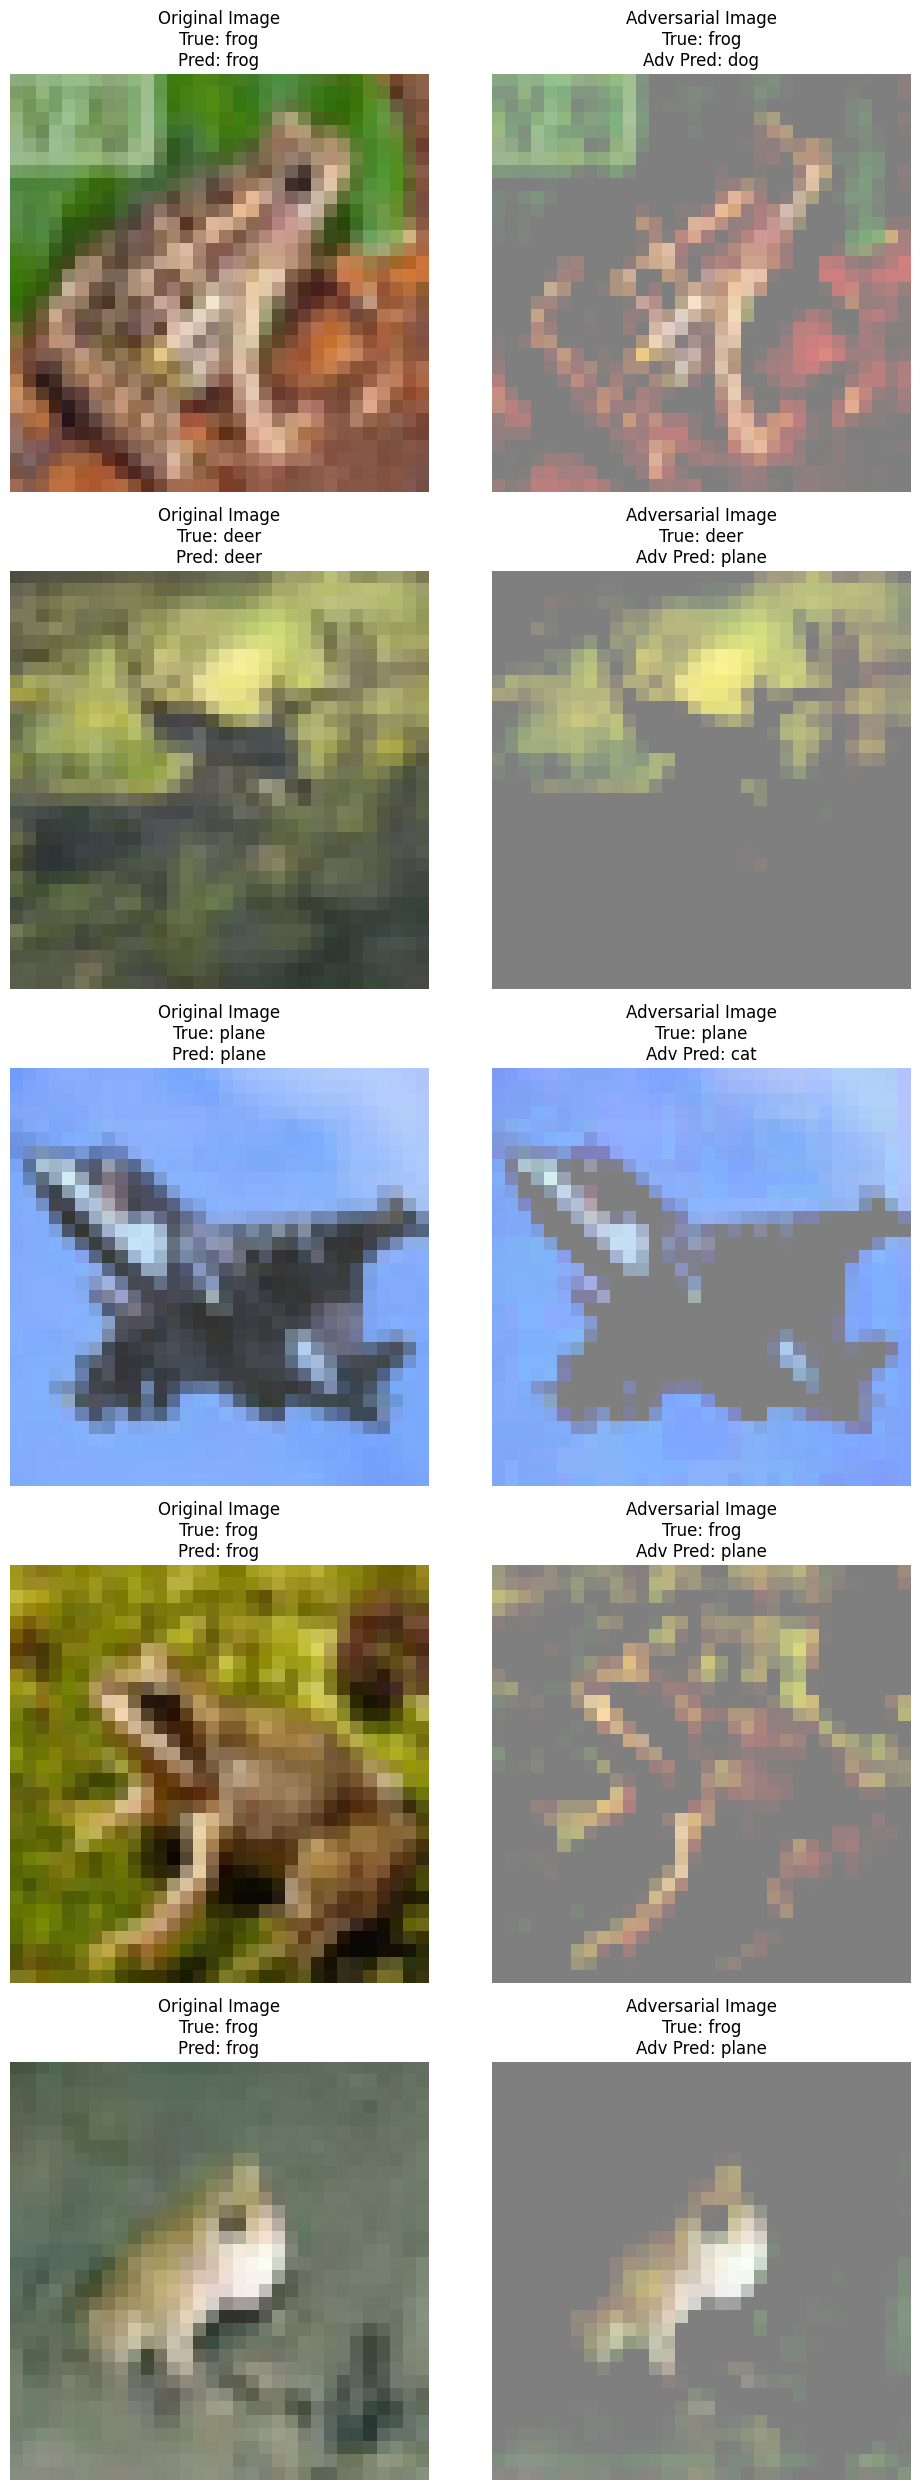

In [25]:
import torchattacks

attack_square = torchattacks.Square(model, norm='Linf', eps=8/255, n_queries=5000, p_init=0.8)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_square(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Success Rate: 0.3750


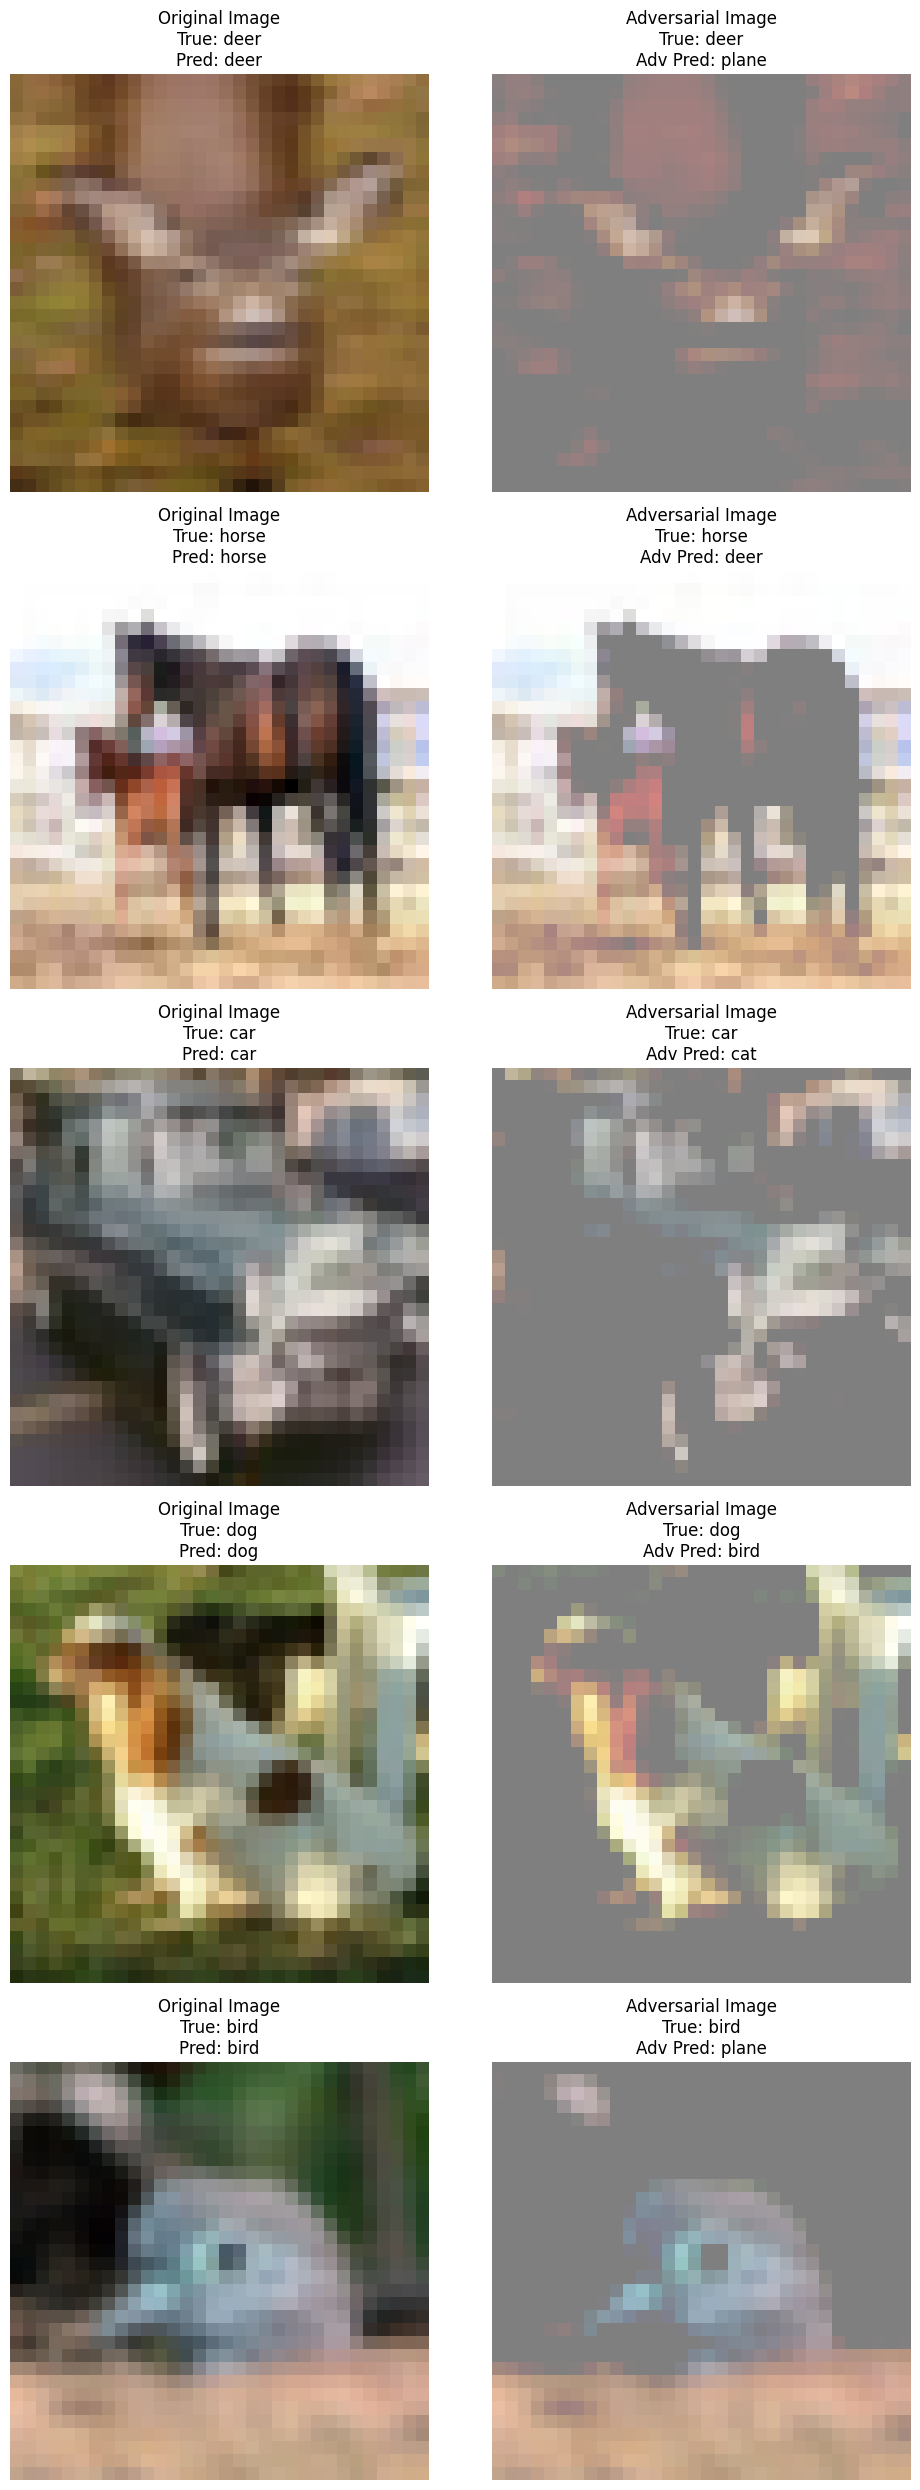

In [26]:
import torchattacks

# Tweak parameters to be opposites
attack_square = torchattacks.Square(model, norm='L2', eps=16/255, n_queries=1000, p_init=0.2)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_square(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Success Rate: 0.3250


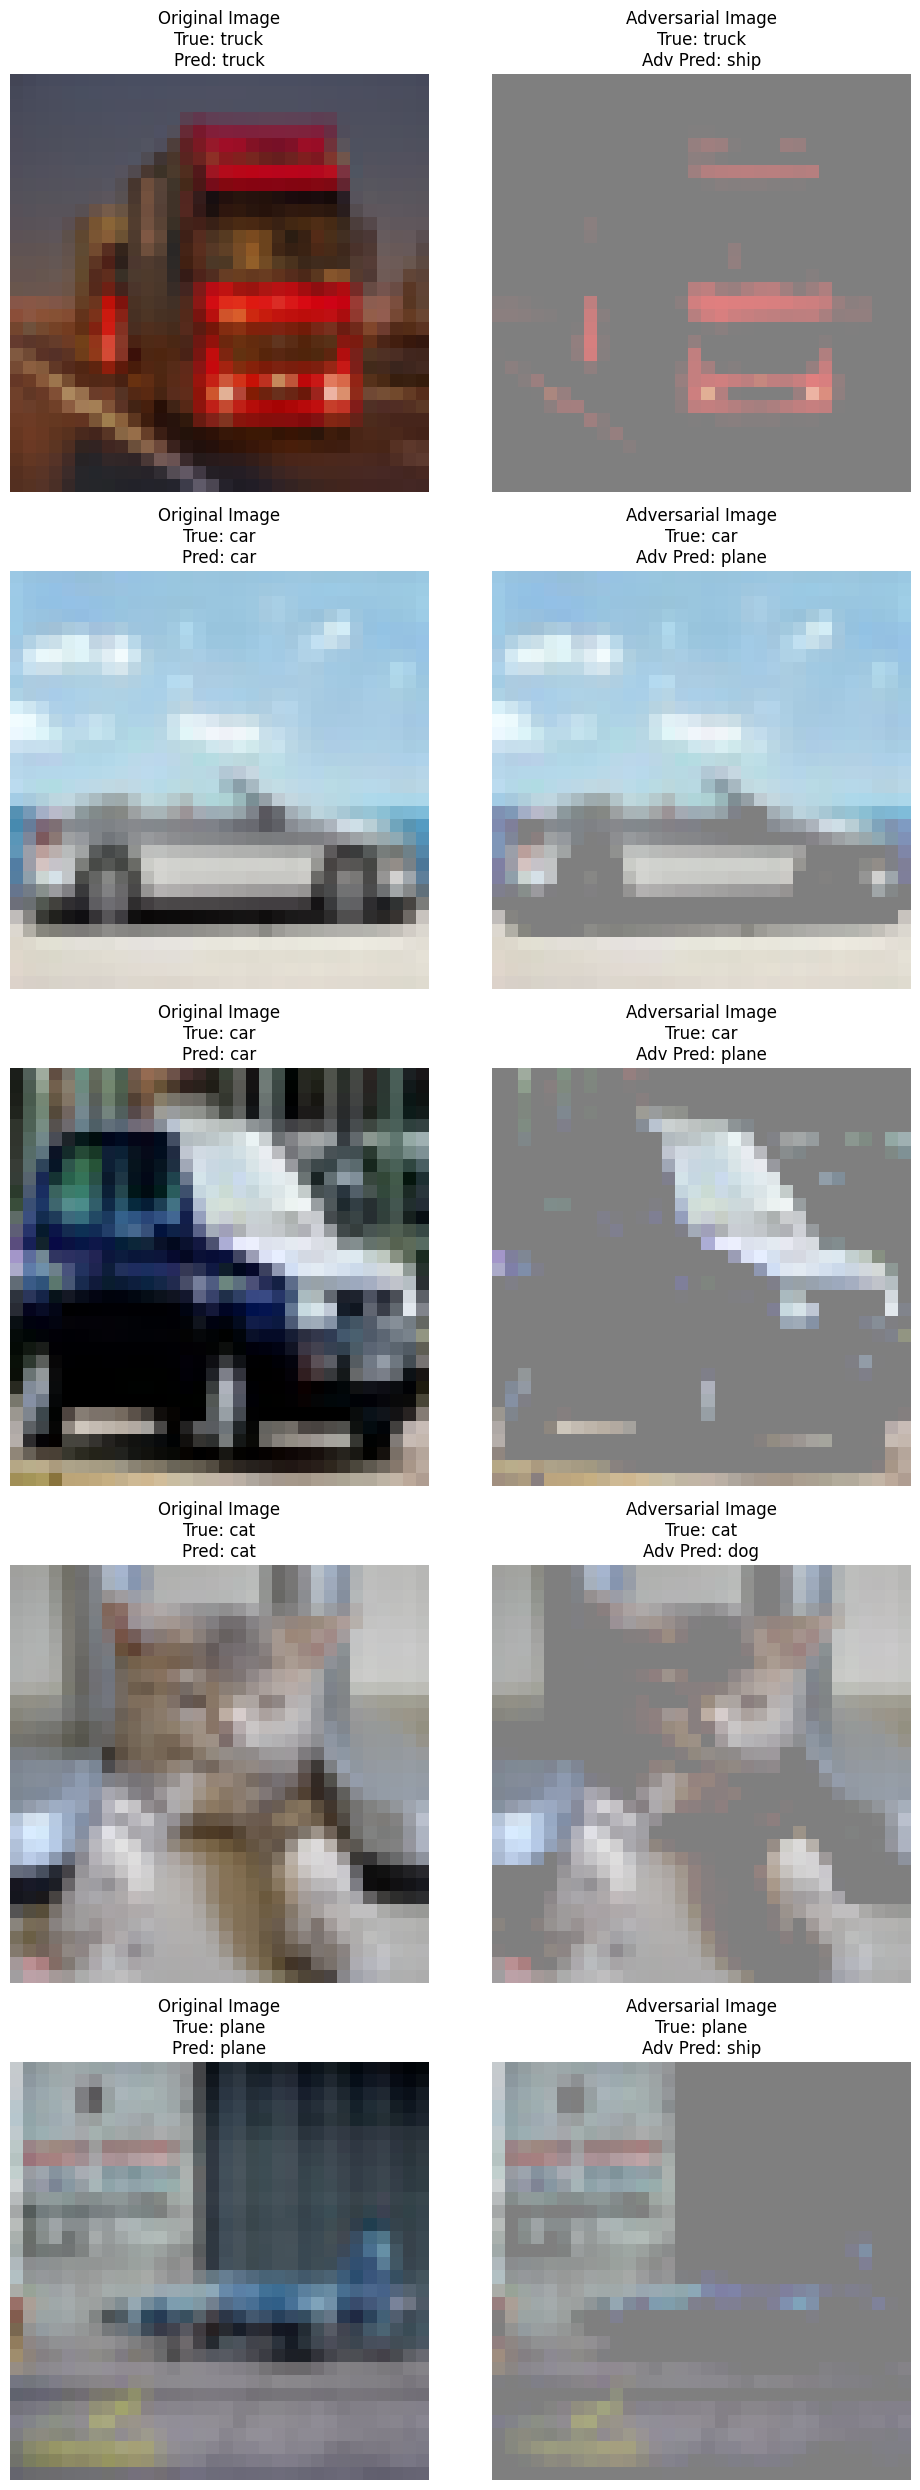

In [27]:
import torchattacks

# Experiment with intermediate parameters
attack_square = torchattacks.Square(model, norm='L2', eps=12/255, n_queries=3000, p_init=0.4)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10
batch_size = 8

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    adv_images = attack_square(images[:batch_size], labels[:batch_size])

    original_predictions = model(images[:batch_size])
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels[:batch_size])):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += len(labels[:batch_size])

    torch.cuda.empty_cache()

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")
